In [69]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
import cv2

In [72]:
import numpy as np

def compute_iou(box1, box2):
    """
    Compute Intersection over Union (IoU) between two bounding boxes.
    Args:
        box1 (tuple): (x, y, w, h) for the first box.
        box2 (tuple): (x, y, w, h) for the second box.
    Returns:
        float: IoU value.
    """
    x1, y1, w1, h1 = box1
    x2, y2, w2, h2 = box2

    # Calculate (x, y) coordinates for intersection
    inter_x1 = max(x1, x2)
    inter_y1 = max(y1, y2)
    inter_x2 = min(x1 + w1, x2 + w2)
    inter_y2 = min(y1 + h1, y2 + h2)

    # Compute intersection area
    inter_area = max(0, inter_x2 - inter_x1) * max(0, inter_y2 - inter_y1)

    # Compute union area
    box1_area = w1 * h1
    box2_area = w2 * h2
    union_area = box1_area + box2_area - inter_area

    return inter_area / union_area if union_area > 0 else 0

def non_max_suppression(boxes, overlapThreshold):
    """
    Perform Non-Maximum Suppression (NMS) based on IoU.
    Args:
        boxes (List[Tuple]): List of (x, y, w, h) bounding boxes.
        overlapThreshold (float): IoU threshold for suppression.
    Returns:
        List: Suppressed bounding boxes.
    """
    if len(boxes) == 0:
        return []

    # Convert to numpy array for easier operations
    boxes = np.array(boxes)
    
    # Sort boxes by bottom-right y-coordinate (so we start suppressing from bottom)
    idxs = np.argsort(boxes[:, 1] + boxes[:, 3])
    
    keep_boxes = []

    while len(idxs) > 0:
        # Pick the last box (the one with the highest bottom y-coordinate)
        last = idxs[-1]
        keep_boxes.append(tuple(boxes[last]))

        # Compute IoU for the remaining boxes
        ious = np.array([compute_iou(boxes[last], boxes[i]) for i in idxs[:-1]])

        # Keep only boxes with IoU below the threshold
        idxs = np.delete(idxs, np.concatenate(([len(idxs) - 1], np.where(ious > overlapThreshold)[0])))

    return keep_boxes

def find_objects(img, template_paths, objects, scales, threshold=0.5, mask_value=230, output_path=None):
    """
    Find objects in an image using template matching.
    Args:
        img (np.ndarray): The image to match the templates to.
        template_paths (list): List of paths to the templates.
        objects (list): List of labels for the objects.
        scales (np.ndarray): Array of scales to resize the templates.
        threshold (float): Threshold for the match.
        mask_value (int): Mask values bigger than this to 0.
        output_path (str): Path to save the output image (None to not save).        
    """
    
    boxes = []
    copy = img.copy()

    for template_path, label in zip(template_paths, objects):
        print(f'Searching for {label}...')
        template = cv.imread(template_path, 0)

        template_mask = np.where(template < mask_value, 1, 0).astype(np.uint8)

        best_match = None
        best_val = -1

        for scale in scales:
            resized_template = cv.resize(template, (0, 0), fx=scale, fy=scale)
            resized_mask = cv.resize(template_mask, (0, 0), fx=scale, fy=scale)

            w, h = resized_template.shape[::-1]
            result = cv.matchTemplate(img, resized_template, cv.TM_CCORR_NORMED, mask=resized_mask)
            plt.imshow(result, cmap='gray')

            _, max_val, _, max_loc = cv.minMaxLoc(result)

            if max_val > best_val:
                best_val = max_val
                best_match = (*max_loc, w, h)

        if best_match and best_val >= threshold:
            boxes.append(best_match)

    for box in boxes:
        x, y, w, h = box
        cv.rectangle(copy, (x, y), (x + w, y + h), (0, 0, 255), thickness=4)
        cv.putText(copy, label, (x, y - 10), cv.FONT_HERSHEY_SIMPLEX, fontScale=3, color=(0, 0, 0), thickness=5)
        
    if output_path:
        cv.imwrite(output_path, copy)
        
    plt.imshow(copy, cmap='gray')
    plt.show()

def count_objects(img, template_paths, objects, scales, threshold=0.5,  output_path=None, suppression_value=0.05):
    """
    Count objects in an image using template matching.
    Args:
        img (np.ndarray): The image to match the templates to.
        template_paths (list): List of paths to the templates.
        objects (list): List of labels for the objects.
        scales (np.ndarray): Array of scales to resize the templates.
        threshold (float): Threshold for the match.
        output_path (str): Path to save the output image (None to not save).
        suppression_value (float): Threshold for the overlap.
    """
    copy = img.copy()

    boxes = []
    
    for template_path, label in zip(template_paths, objects):
        print(f'Searching for {label}...')
        template = cv.imread(template_path, 0)

        for scale in scales:
            resized_template = cv.resize(template, (0, 0), fx=scale, fy=scale)
            w, h = resized_template.shape[::-1]

            result = cv.matchTemplate(img, resized_template, cv.TM_CCOEFF_NORMED)

            # Get matches with a value above the threshold
            loc = np.where(result >= threshold)
            for top_pos in zip(*loc[::-1]):
                boxes.append((*top_pos, w, h))

    boxes =  non_max_suppression(boxes, suppression_value)

    for box in boxes:
        x, y, w, h = box
        cv.rectangle(copy, (x, y), (x + w, y + h), (0, 0, 255), thickness=4)
        cv.putText(copy, label, (x, y - 10), cv.FONT_HERSHEY_SIMPLEX, fontScale=1, color=(0, 0, 0), thickness=5)

    plt.figure(figsize=(10, 10))
    plt.imshow(copy, cmap='gray')
    plt.title(f'Count: {len(boxes)}')
    if output_path:
        plt.savefig(output_path)

    plt.show()

### finding objects

In [29]:
img_path_1 = '/Users/khai/Documents/GitHub/Finding-or-Counting-objects-in-images/data/finding/1/1_target.jpg'
objects_1 = ['ball', 'bear', 'boat', 'bowtie', 'cake', 'car', 'duck', 'grape', 'horse', 'icecream', 'melon', 'rabbit', 'strawberry', 'train']
template_paths_1 = [f'/Users/khai/Documents/GitHub/Finding-or-Counting-objects-in-images/data/finding/1/1_{object}.jpg' for object in objects_1]

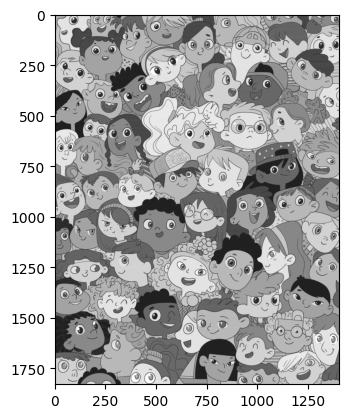

In [30]:
img = cv.imread(img_path_1, 0)
plt.imshow(img, cmap='gray')

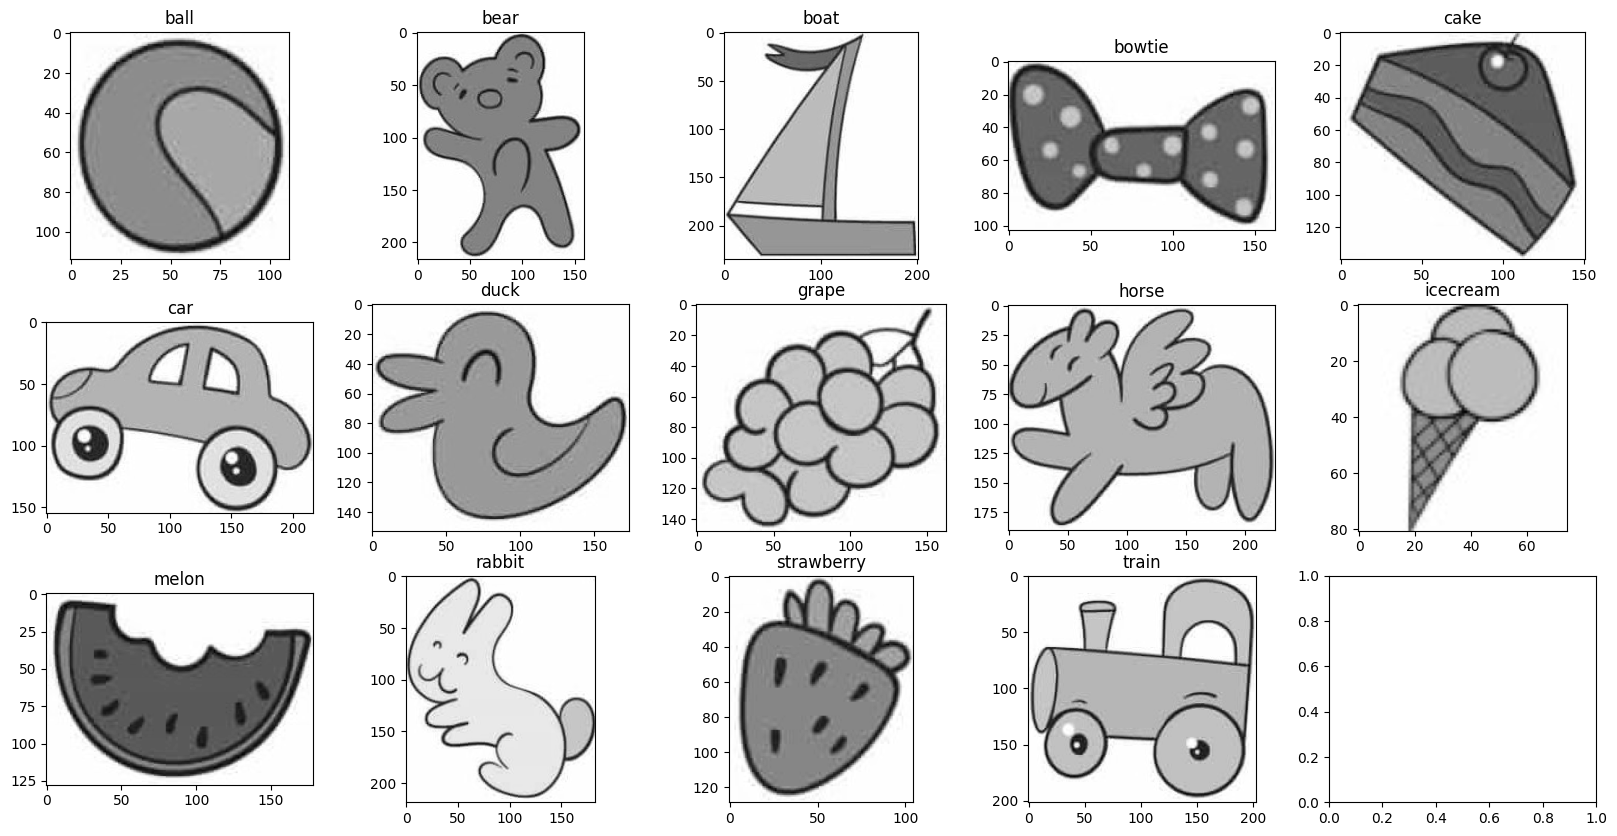

In [31]:
fig, axes = plt.subplots(3, 5, figsize=(20, 10))
axes = axes.flatten()

for i, template_path in enumerate(template_paths_1):
    template = cv.imread(template_path, 0)
    axes[i].imshow(template, cmap='gray')
    axes[i].set_title(objects_1[i])
plt.show()

Searching for ball...
Searching for bear...
Searching for boat...
Searching for bowtie...
Searching for cake...
Searching for car...
Searching for duck...
Searching for grape...
Searching for horse...
Searching for icecream...
Searching for melon...
Searching for rabbit...
Searching for strawberry...
Searching for train...


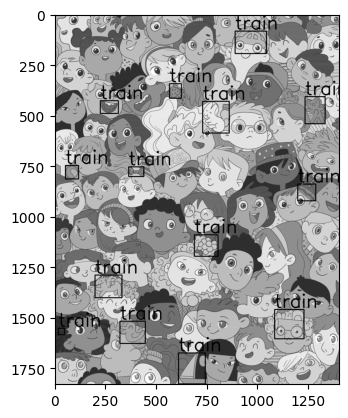

In [32]:
threshold = 0.5
scales = np.linspace(0.4, 1.0, 20)

find_objects(img=img, template_paths=template_paths_1, objects=objects_1, scales=scales, threshold=threshold)


In [33]:
img_path_2 = '/Users/khai/Documents/GitHub/Finding-or-Counting-objects-in-images/data/finding/2/2_target.jpg'

objects_2 = ['ball', 'baloon', 'bone', 'bowtie', 'butterfly', 'cheese', 'chicken', 'cloud', 'icecream', 'icecreamcone', 'sausage', 'strawberry']
template_paths_2 = [f'/Users/khai/Documents/GitHub/Finding-or-Counting-objects-in-images/data/finding/2/2_{object}.jpg' for object in objects_2]

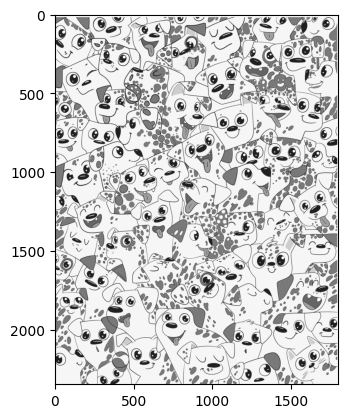

In [34]:
img = cv.imread(img_path_2, 0)
plt.imshow(img, cmap='gray')

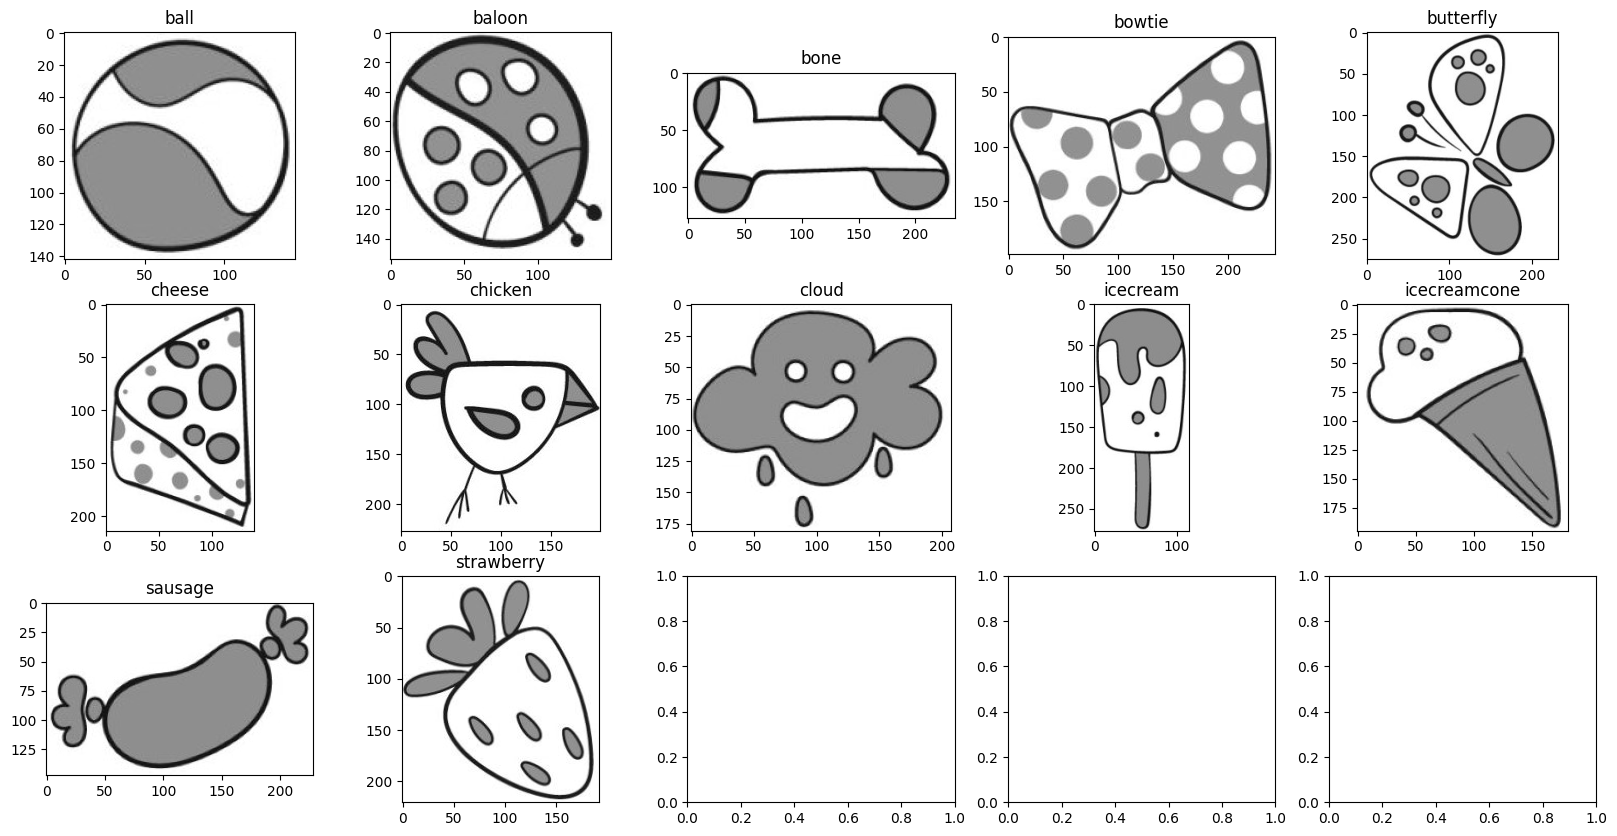

In [35]:
fig, axes = plt.subplots(3, 5, figsize=(20, 10))
axes = axes.flatten()

for i, template_path in enumerate(template_paths_2):
    template = cv.imread(template_path, 0)
    axes[i].imshow(template, cmap='gray')
    axes[i].set_title(objects_2[i])
plt.show()

Searching for ball...
Searching for bear...
Searching for boat...
Searching for bowtie...
Searching for cake...
Searching for car...
Searching for duck...
Searching for grape...
Searching for horse...
Searching for icecream...
Searching for melon...
Searching for rabbit...
Searching for strawberry...
Searching for train...


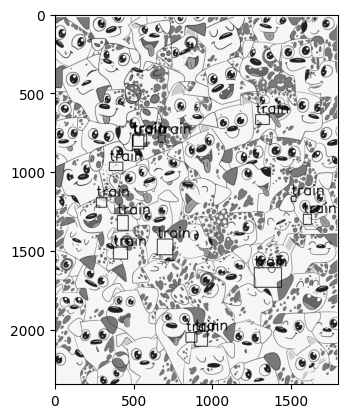

In [36]:
threshold = 0.5
scales = np.linspace(0.4, 1.0, 20)

find_objects(img=img, template_paths=template_paths_1, objects=objects_1, scales=scales, threshold=threshold)


### Coutding object

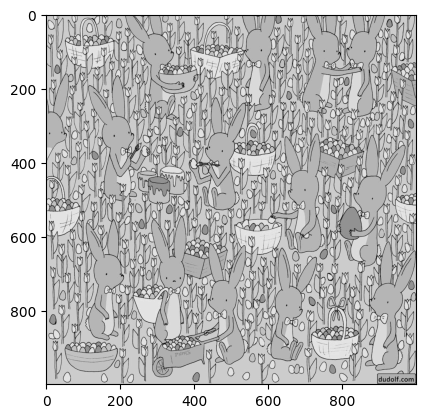

In [40]:
img = cv.imread('/Users/khai/Documents/GitHub/Finding-or-Counting-objects-in-images/data/counting/rabbit/rabbit.jpeg', 0)
template_paths = ['/Users/khai/Documents/GitHub/Finding-or-Counting-objects-in-images/data/counting/rabbit/rabbit_template.jpeg', '/Users/khai/Documents/GitHub/Finding-or-Counting-objects-in-images/data/counting/rabbit/rabbit_template3.jpeg', '/Users/khai/Documents/GitHub/Finding-or-Counting-objects-in-images/data/counting/rabbit/rabbit_template4.jpeg']
objects = ['rabbit', 'rabbit', 'rabbit']

img = cv.imread('/Users/khai/Documents/GitHub/Finding-or-Counting-objects-in-images/data/counting/rabbit/rabbit.jpeg', 0)
plt.imshow(img, cmap='gray')

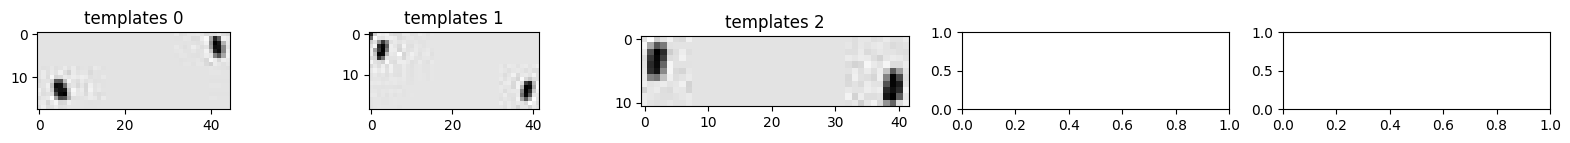

In [42]:
fig, axes = plt.subplots(1, 5, figsize=(20, 1))
axes = axes.flatten()

for i, template_path in enumerate(template_paths):
    template = cv.imread(template_path, 0)
    axes[i].imshow(template, cmap='gray')
    axes[i].set_title(f'templates {i}')
plt.show()

Searching for rabbit...
Searching for rabbit...
Searching for rabbit...


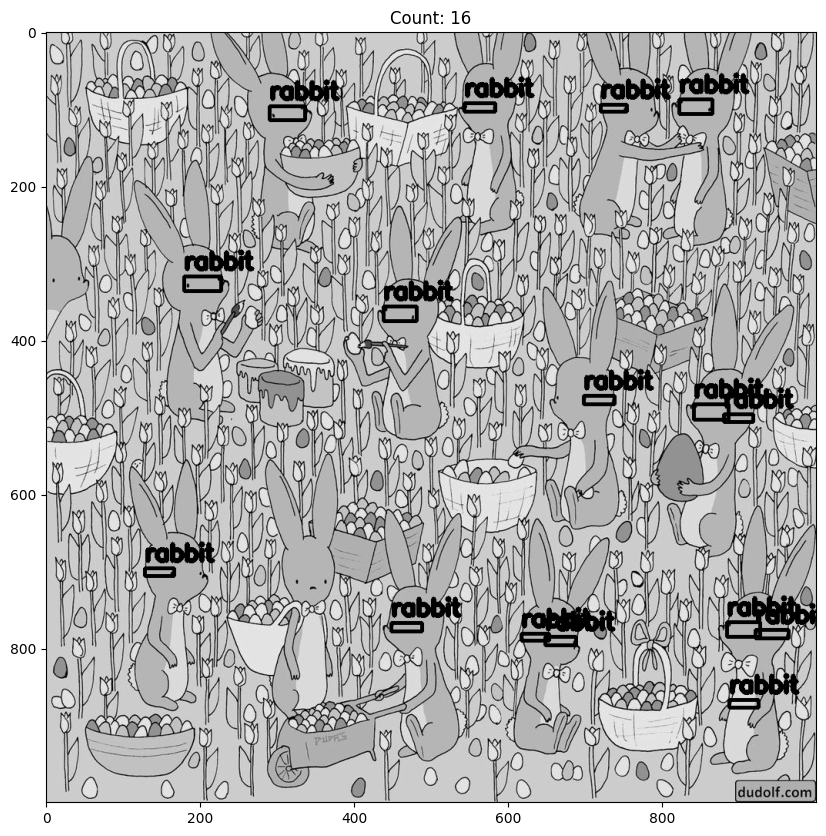

In [73]:
threshold = 0.69
scales = np.linspace(0.8, 1.4, 12)

count_objects(img=img, template_paths=template_paths, objects=objects, scales=scales, threshold=threshold, output_path="res4", suppression_value=0.05)

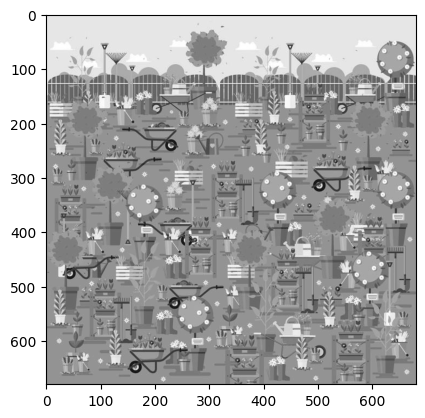

In [75]:
img = cv.imread('/Users/khai/Documents/GitHub/Finding-or-Counting-objects-in-images/data/counting/pair_boot/pair_boot.jpg', 0)
template_paths = ['/Users/khai/Documents/GitHub/Finding-or-Counting-objects-in-images/data/counting/pair_boot/pair_boot_template2.jpg']
objects = ['!']

plt.imshow(img, cmap='gray')

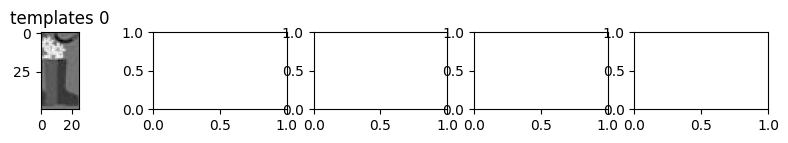

In [76]:
fig, axes = plt.subplots(1, 5, figsize=(10, 1))
axes = axes.flatten()

for i, template_path in enumerate(template_paths):
    template = cv.imread(template_path, 0)
    axes[i].imshow(template, cmap='gray')
    axes[i].set_title(f'templates {i}')
plt.show()

Searching for !...


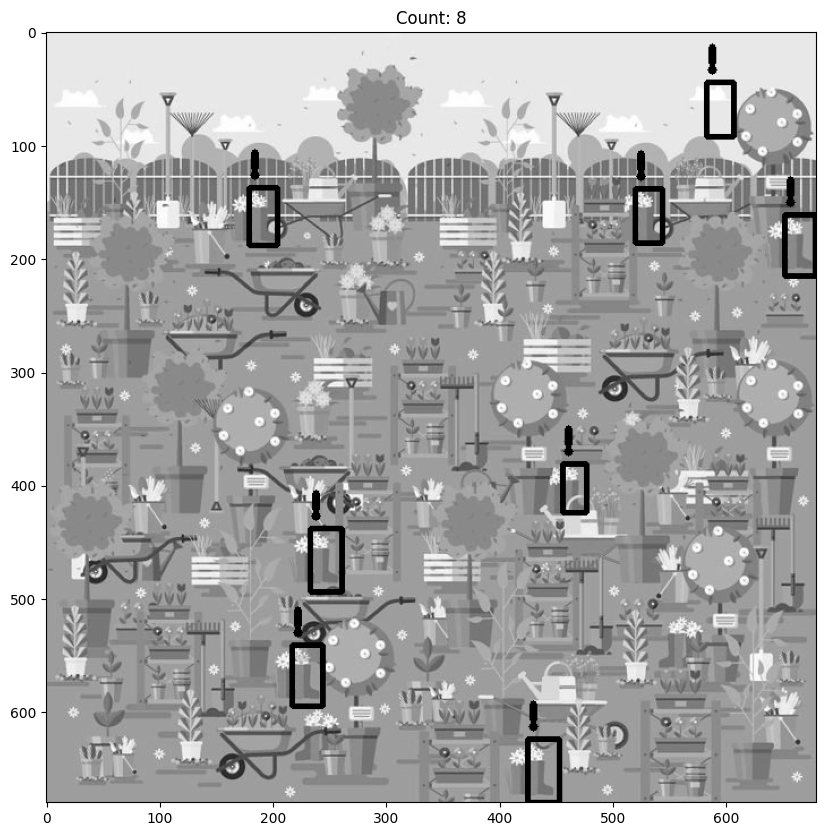

In [77]:
threshold = 0.7
scales = np.linspace(0.8, 1.4, 12)

count_objects(img=img, template_paths=template_paths, objects=objects, scales=scales, threshold=threshold, output_path="res4", suppression_value=0.05)